In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('retina')
plt.rc('text', usetex=True)
plt.rc('figure', figsize=[10, 10])
plt.rc('font', size=18)

In [3]:
import random
from os.path import join
from typing import Tuple, List

import arff
from snapshottest import TestCase

from src import DEFAULT_DIR
from src.XPLAIN_explainer import XPLAIN_explainer
from src.dataset import Dataset


def load_arff(f):
    a = arff.load(f)
    dataset = Dataset(a['data'], a['attributes'])

    return dataset


def import_dataset_arff(f, explain_indices: List[int],
                        random_explain_dataset: bool) -> Tuple[Dataset, Dataset, List[str]]:
    dataset = load_arff(f)

    dataset_len = len(dataset)
    train_indices = list(range(dataset_len))

    if random_explain_dataset:
        random.seed(1)
        # small dataset
        MAX_SAMPLE_COUNT = 100
        if dataset_len < (2 * MAX_SAMPLE_COUNT):
            samples = int(0.2 * dataset_len)
        else:
            samples = MAX_SAMPLE_COUNT

        # Randomly pick some instances to remove from the training dataset and use in the
        # explain dataset
        explain_indices = list(random.sample(train_indices, samples))
    for i in explain_indices:
        train_indices.remove(i)

    train_dataset = Dataset.from_indices(train_indices, dataset)
    explain_dataset = Dataset.from_indices(explain_indices, dataset)

    return train_dataset, explain_dataset, [str(i) for i in explain_indices]



def get_classifier(classifier_name: str):
    if classifier_name == "sklearn_categorical_nb":
        from sklearn.naive_bayes import CategoricalNB

        skl_clf = CategoricalNB()

        return skl_clf

    if classifier_name == "sklearn_rf":
        from sklearn.ensemble import RandomForestClassifier

        skl_clf = RandomForestClassifier(random_state=42)

        return skl_clf

    if classifier_name == "nn_onehot_enc":
        from sklearn.neural_network import MLPClassifier
        from sklearn.pipeline import make_pipeline
        from sklearn.preprocessing import OneHotEncoder

        pipe = make_pipeline(OneHotEncoder(), MLPClassifier(random_state=42, max_iter=1000))
        skl_clf = pipe

        return skl_clf
  
    raise ValueError("Classifier not available")

def evaluate(ds, cln):
    from sklearn.metrics import accuracy_score
    with open(ds) as f:
            train_dataset, explain_dataset, explain_indices = import_dataset_arff(
                f, [], True)

    clf = get_classifier(cln).fit(train_dataset.X_numpy(),
                                                  train_dataset.Y_numpy())
    return accuracy_score(clf.predict(explain_dataset.X_numpy()), explain_dataset.Y_numpy())
    

def get_explanation(ix:int, dataset_name: str, classifier_name: str, manual_target_class=None):
    with open(dataset_name) as f:
        train_dataset, explain_dataset, explain_indices = import_dataset_arff(
            f, [], True)

    clf = get_classifier(classifier_name).fit(train_dataset.X_numpy(),
                                              train_dataset.Y_numpy())
    explainer = XPLAIN_explainer(clf, train_dataset)

    instance = explain_dataset.get_decoded(ix)

    cc = explain_dataset.class_column_name()
    decoded_target_class = instance[cc]

    return explainer.explain_instance(
        explain_dataset[ix],
        manual_target_class if manual_target_class != None else decoded_target_class
    )

/home/andrea/Documents/Politecnico/tirocinio/src/../


In [4]:
def plot(e):

    fig, pred_ax = plt.subplots(1, 1)
    
    attrs = [f"{k}" for k,v in (e['instance'].items())][:-1]
    values = [f"{k}={v}" for k,v in (e['instance'].items())]
    
    pred_ax.set_title(
f"""Importance
$P[y={e['target_class']} | x=({", ".join(values)})]={e['prob']:.3f}$""", pad=12
    )
    pred_ax.set_ylabel("Attribute or rule", labelpad=2)
    pred_ax.set_xlabel(fr"${e['prob']:.3f} - P[y={e['target_class']} | x \setminus A_i]$",labelpad=12)
    
    pred_ax.grid(True)
    
    pred_ax.barh(
        attrs + [",".join([(lambda x: f"{x[0]}")(list(e['instance'].to_dict().items())[int(a)-1]) for a in ats.split(',')]) for ats in e['map_difference'].keys()],
        width=e['diff_single'] + list(e['map_difference'].values())
    )

# Monks
`MONK-1: (a == b) or (e == 1)`

## Categorical Naive Bayes
https://scikit-learn.org/stable/modules/naive_bayes.html#categorical-naive-bayes

In [5]:
evaluate(join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_categorical_nb")

0.8

### Instance 0

In [6]:
def get_probabilities(i, ds, cln):
    from sklearn.metrics import accuracy_score
    with open(ds) as f:
            train_dataset, explain_dataset, explain_indices = import_dataset_arff(
                f, [], True)

    clf = get_classifier(cln).fit(train_dataset.X_numpy(),
                                                  train_dataset.Y_numpy())
    return clf.predict_proba([explain_dataset.X_numpy()[i]])
get_probabilities(0, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_categorical_nb")

array([[0.70114782, 0.29885218]])

Questa istanza e' mispredicted dal classifier, a==b, e!=1 quindi y=1 perche' a==b. Naive bayes invece dice che y=0

compute_lace_step k=21
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=42
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=63
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=84
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=105
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=126
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=147
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1

{1, 2, 3, 4, 15} a=1, b=1, c=1, d=2, e=1 -> 1

Rules: []

compute_lace_step k=168
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1

{1, 2, 3, 15} a=1, b=1, c=1, e=1 -> 1

Rules: []

compute_lace_step k=189
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1

{7} c=2 -> 0
{5} e=3 -> 0
{3, 15} c=1, e=1 -> 1

Rules: [[5]]

compute_lace_step k=210
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1

{5} e=3 -> 0
{9} e=4 -> 0
{11} e=2 -> 0
{15} e=1 -> 1

Rules: [[5]]

ex

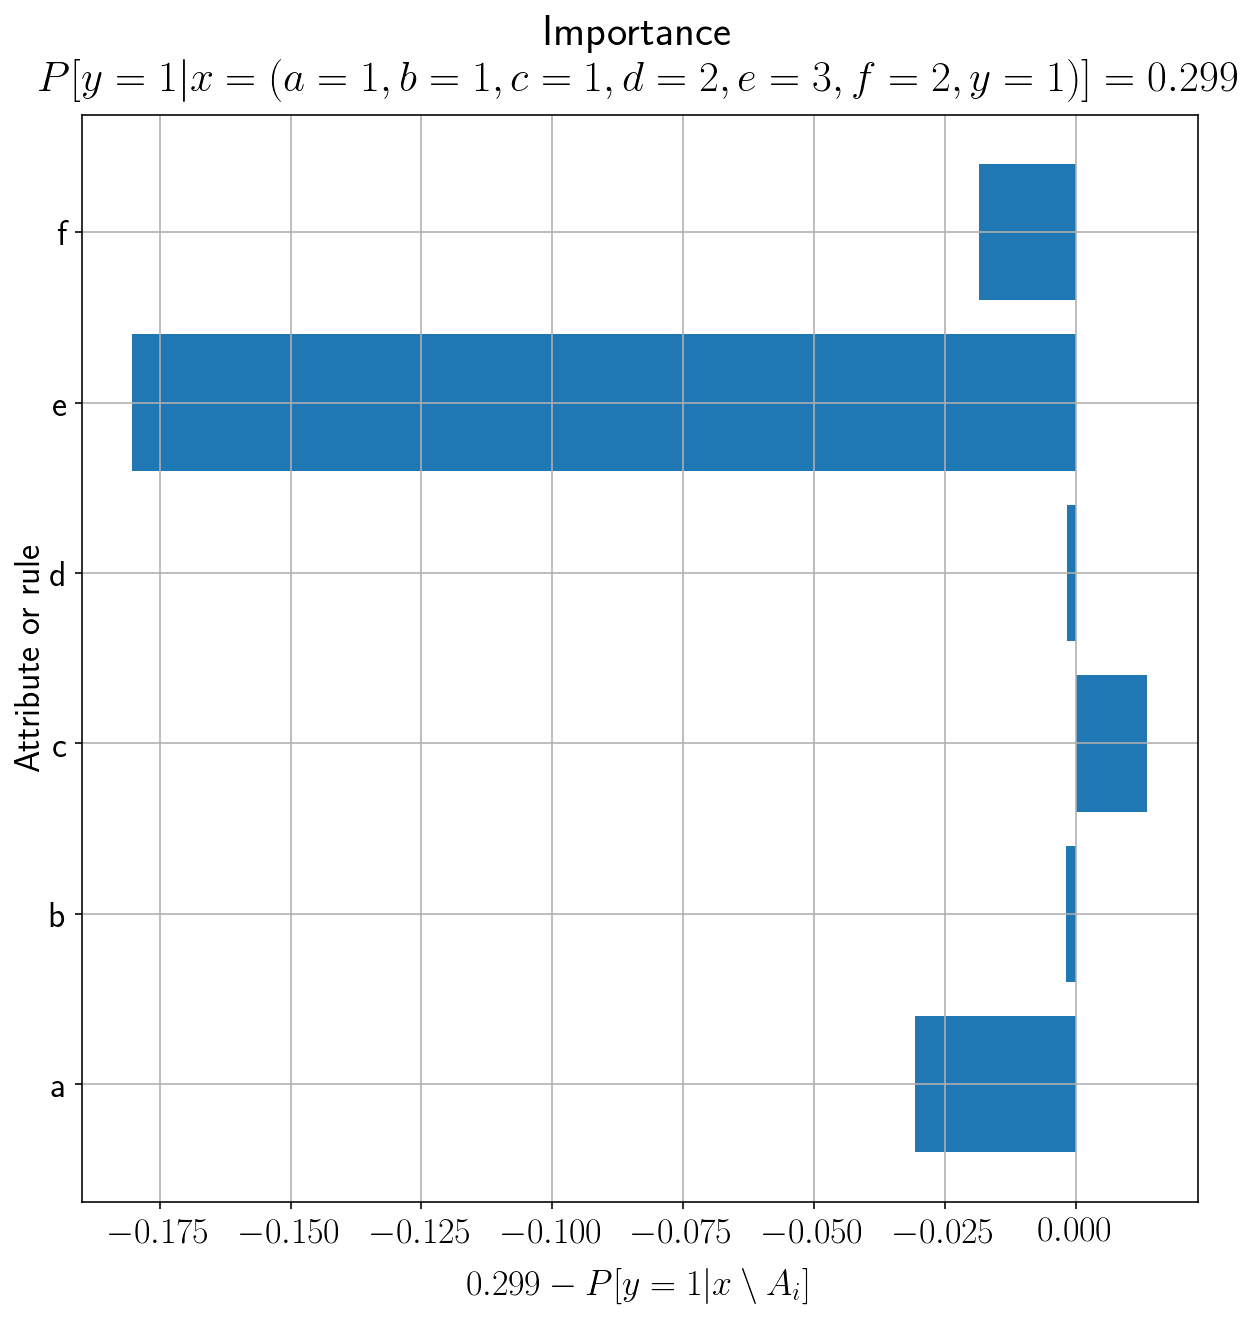

In [7]:
plot(get_explanation(0, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_categorical_nb"))

Analizziamo perche' NB pensa che questa istanza appartenga a 0.

NB vede che e=3 ovvero e!=1 e quindi pensa che y=0. Non si rende conto della dipendenza a==b, vede solo l'attributo e. Poiche' le ipotesi di Naive Bayes considerano tutte gli attributi indipendenti, il classifier non riesce a scoprire la regola a==b

Bisogna anche considerare che nonostante NB sia un buon classificatore, le probabilita' che restituisce non sono ottime.
> While naive Bayes often fails to produce a good estimate for the correct class probabilities,[14] this may not be a requirement for many applications. For example, the naive Bayes classifier will make the correct MAP decision rule classification so long as the correct class is more probable than any other class. This is true regardless of whether the probability estimate is slightly, or even grossly inaccurate.
>
> [14] Niculescu-Mizil, Alexandru; Caruana, Rich (2005). Predicting good probabilities with supervised learning (PDF). ICML. doi:10.1145/1102351.1102430. Archived from the original (PDF) on 2014-03-11. Retrieved 2016-04-24.

compute_lace_step k=21
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=42
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=63
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=84
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=105
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=126
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=147
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1

{1, 2, 3, 4, 15} a=1, b=1, c=1, d=2, e=1 -> 1

Rules: []

compute_lace_step k=168
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1

{1, 2, 3, 15} a=1, b=1, c=1, e=1 -> 1

Rules: []

compute_lace_step k=189
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1

{7} c=2 -> 0
{5} e=3 -> 0
{3, 15} c=1, e=1 -> 1

Rules: [[5]]

compute_lace_step k=210
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1

{5} e=3 -> 0
{9} e=4 -> 0
{11} e=2 -> 0
{15} e=1 -> 1

Rules: [[5]]

ex

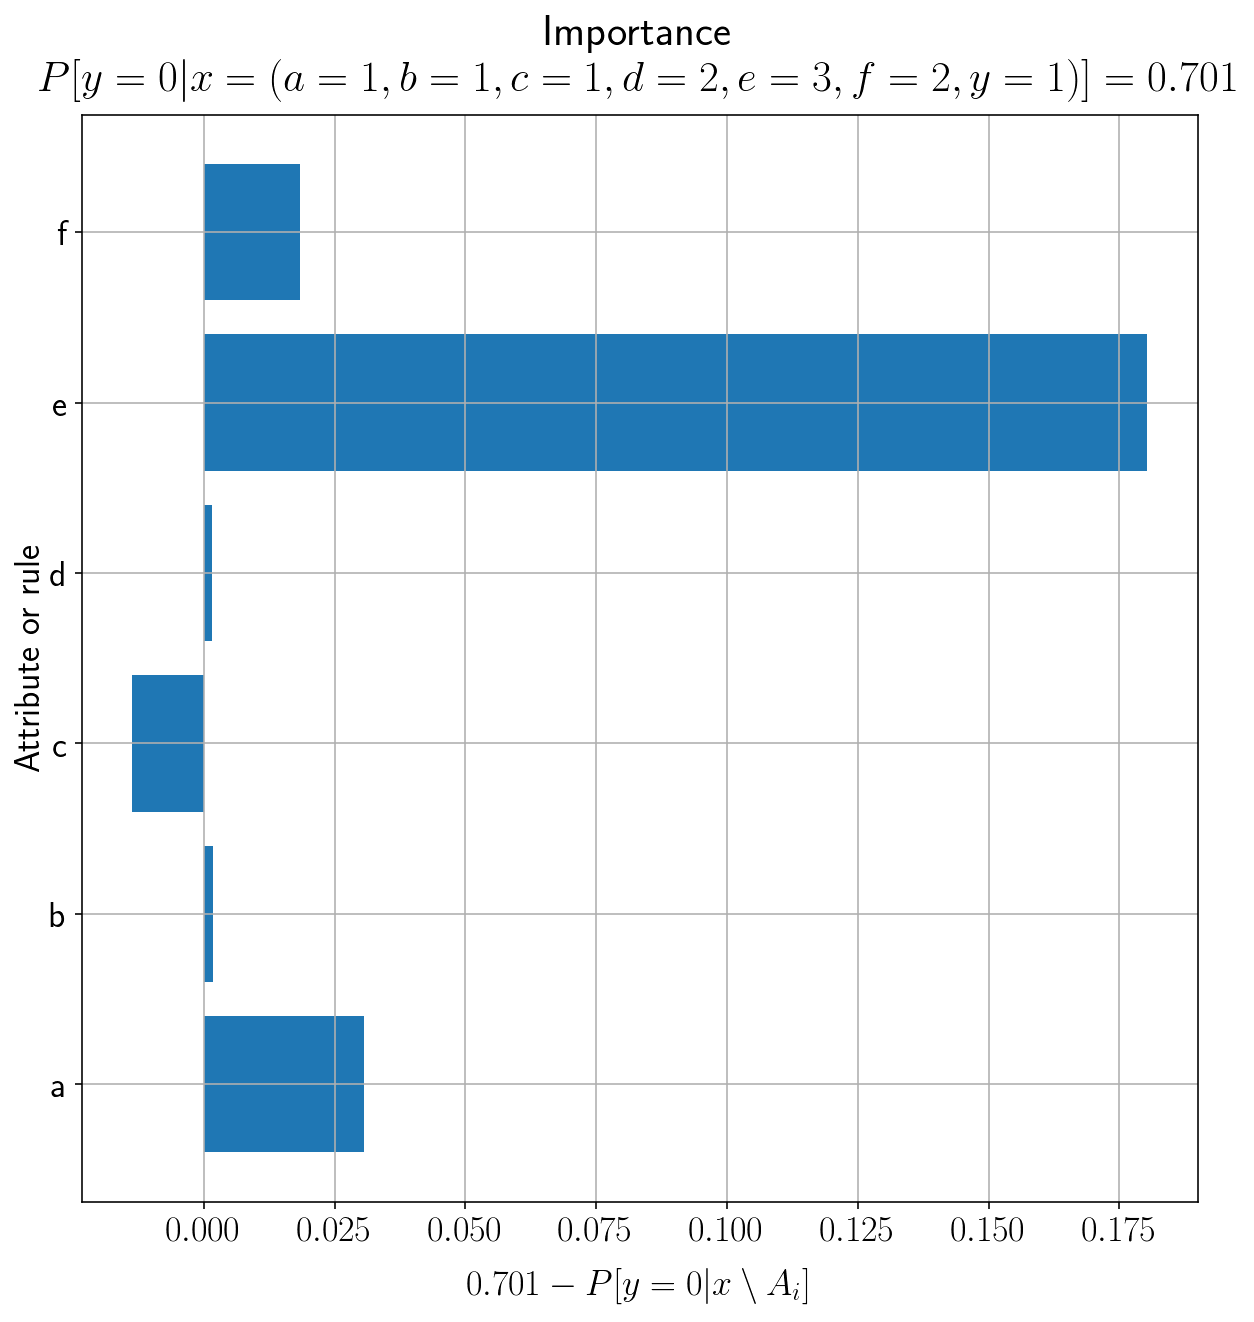

In [8]:
plot(get_explanation(0, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_categorical_nb", manual_target_class='0'))

### 1
Questa istanza e' mispredicted dal classifier, a==b, e!=1 quindi y=1 perche' a==b. Naive bayes invece dice che y=0

compute_lace_step k=21
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=42
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=63
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=84
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=105
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=126
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=147
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=168
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=189
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=210
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1


Rules: []

explain_instance errors: 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01


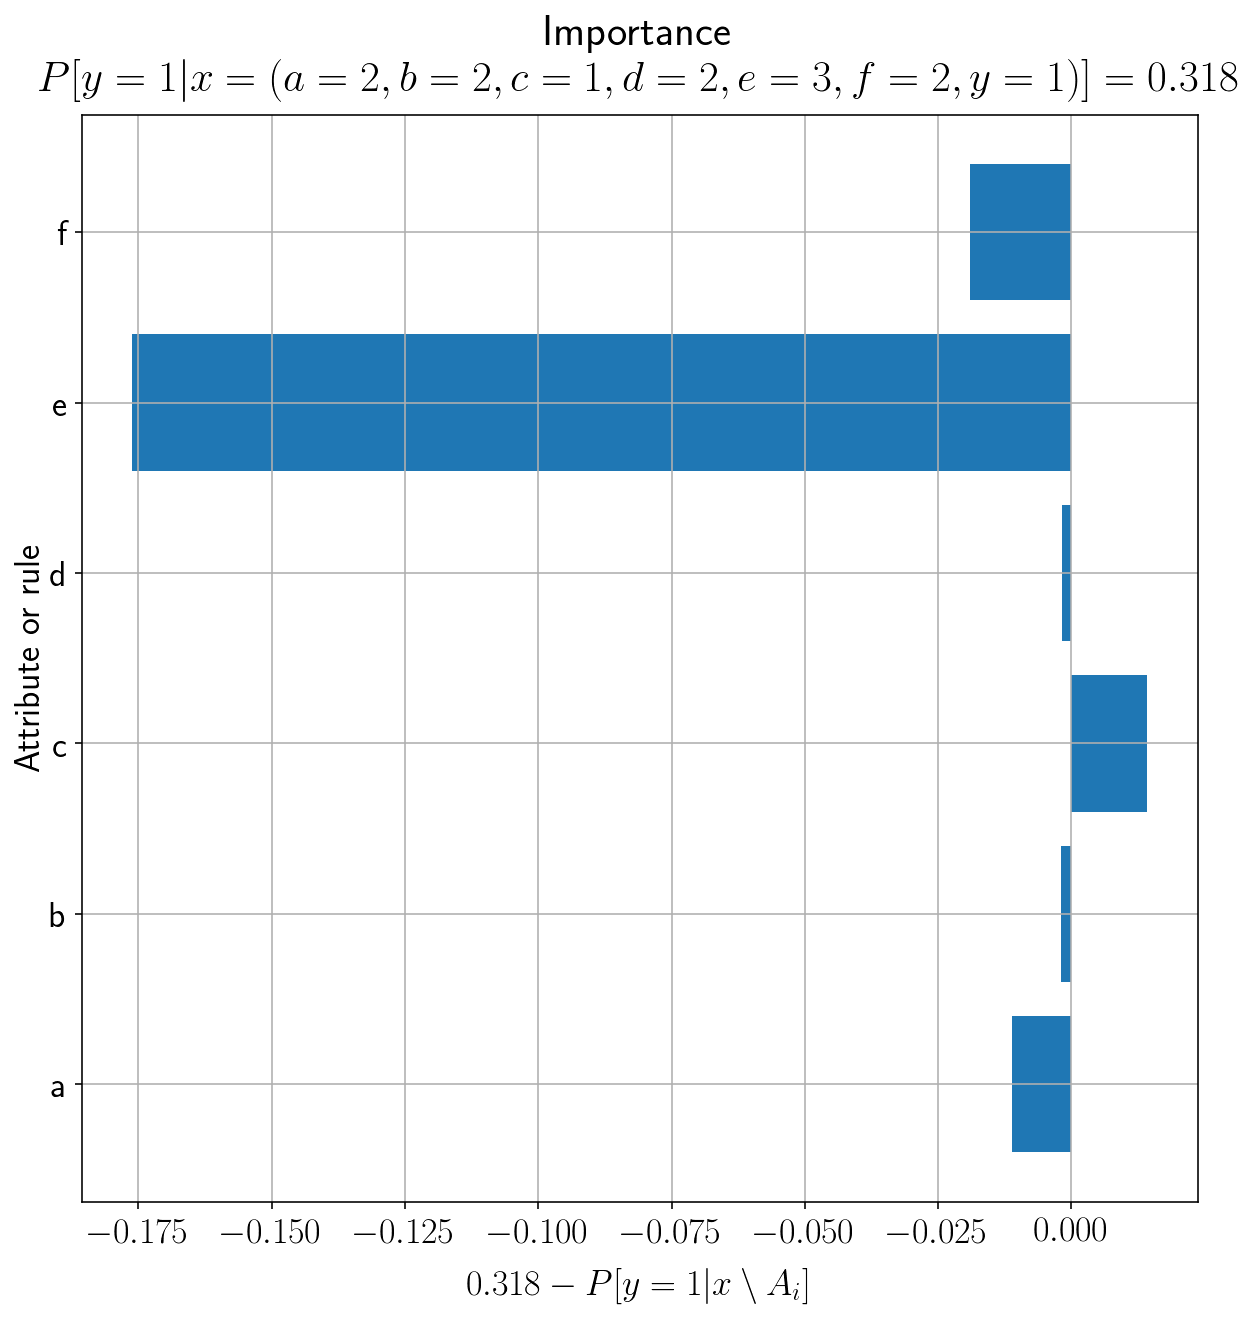

In [9]:
plot(get_explanation(1, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_categorical_nb"))

Analizzando la misprediction, come nel caso precedente vediamo che NB non riesce a capire la regola a==b e si basa solo sul valore di e!=1, cosi' sbagliando la prediction

compute_lace_step k=21
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=42
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=63
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=84
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=105
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=126
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=147
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=168
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=189
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1


Rules: []

compute_lace_step k=210
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1


Rules: []

explain_instance errors: 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01, 1.904E-01


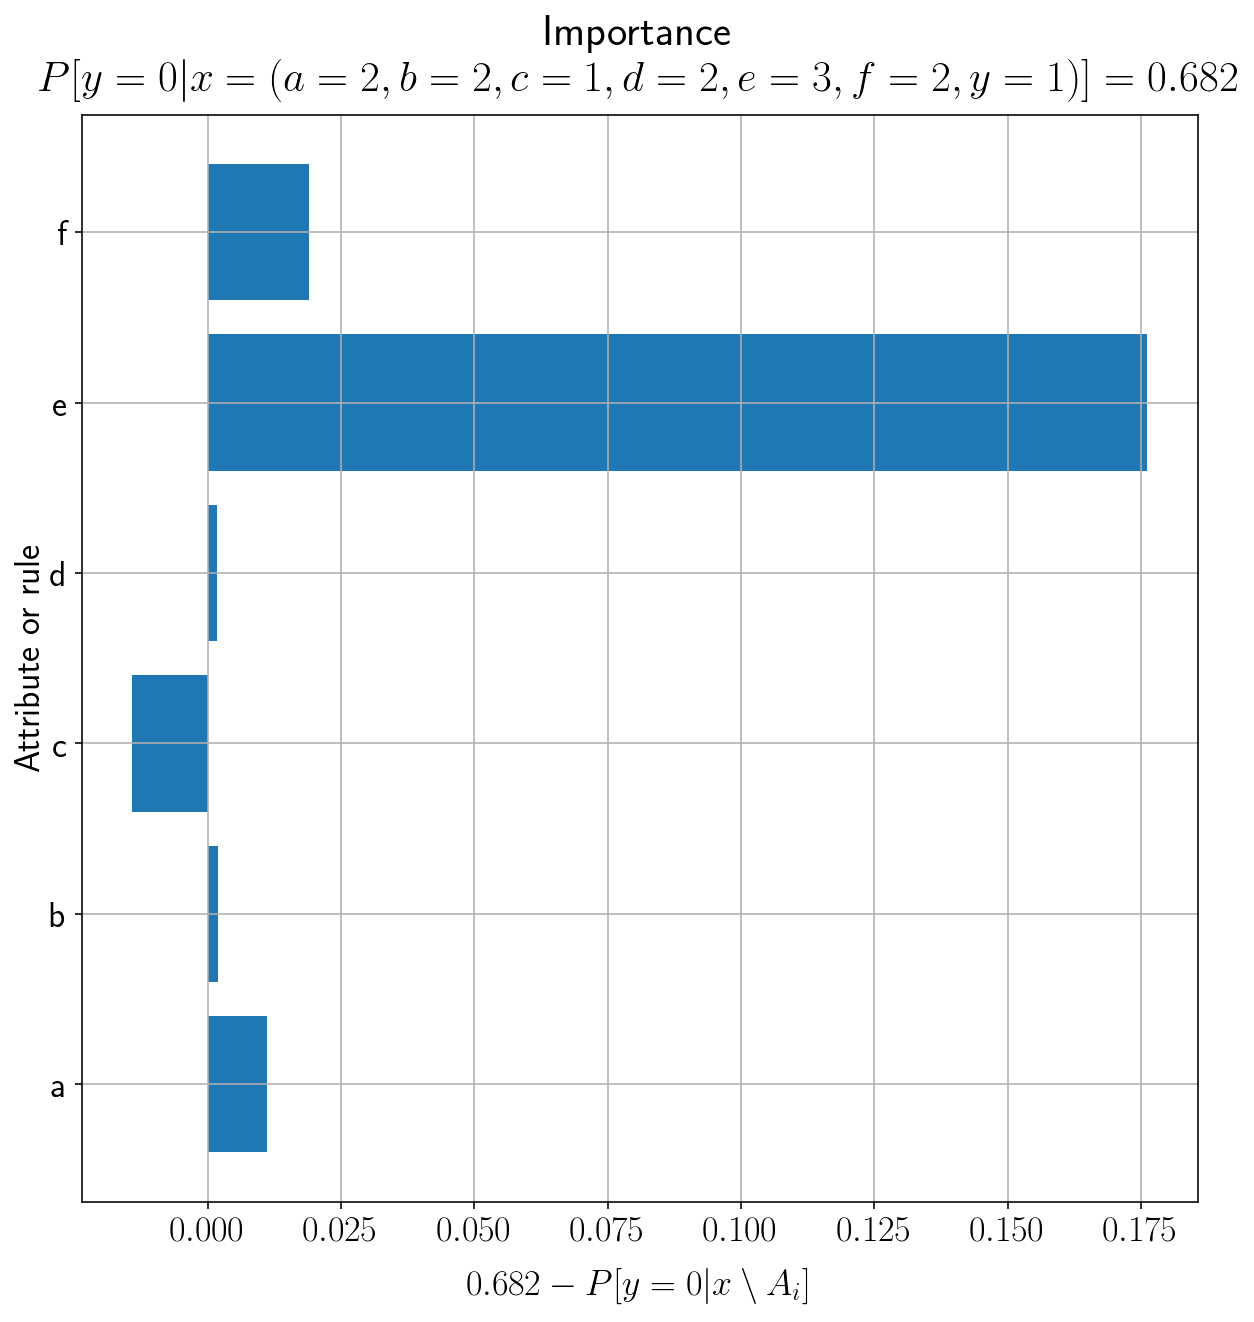

In [10]:
plot(get_explanation(1, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_categorical_nb", manual_target_class='0'))

### 2
a!=b, e==1 quindi y=1 perche' e=1. Giustamente NB da importanza ad e.

compute_lace_step k=21
Instance: a=1, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{3, 12} c=2, e=2 -> 0

Rules: [[5]]

compute_lace_step k=42
Instance: a=1, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{11} e=2 -> 0

Rules: [[5]]

compute_lace_step k=63
Instance: a=1, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{11} e=2 -> 0
{1, 2, 6, 14} a=1, b=3, e=3, f=2 -> 0

Rules: [[5]]

compute_lace_step k=84
Instance: a=1, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{12} e=2 -> 0
{14} e=3 -> 0

Rules: [[5]]

compute_lace_step k=105
Instance: a=1, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{12} e=2 -> 0
{13} e=3 -> 0

Rules: [[5]]

compute_lace_step k=126
Instance: a=1, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{8} e=2 -> 0
{13} e=3 -> 0

Rules: [[5]]

compute_lace_step k=147
Instance: a=1, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{8} e=2 -> 0
{13} e=3 -> 0

Rules: [[5]]

compute_lace_step k=168
Instance: a=1, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{12} e=2 -> 0
{13} e=3 -> 0

Rules: [[5]]

co

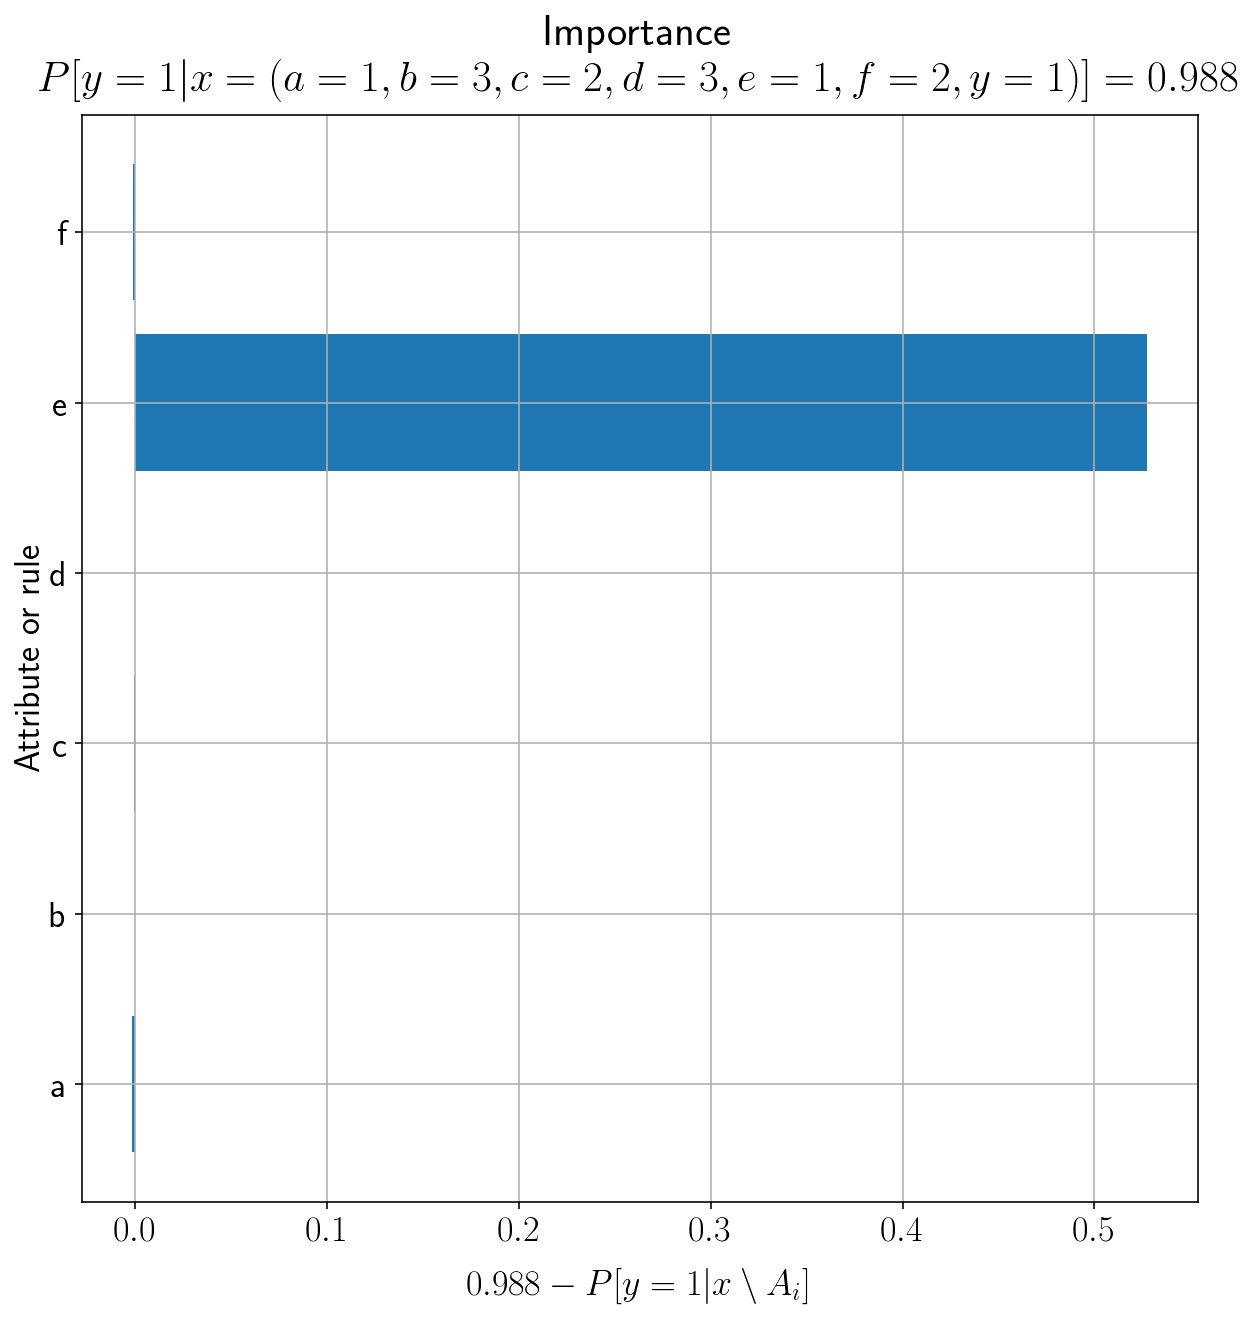

In [11]:
plot(get_explanation(2, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_categorical_nb"))

### 3
a==b, e=1 quindi y=1 perche a==b, e=1. NB riconosce solo l'importanza del valore e=1.

compute_lace_step k=21
Instance: a=3, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{11, 4} d=3, e=2 -> 0

Rules: [[5]]

explain_instance errors: 8.865E-03


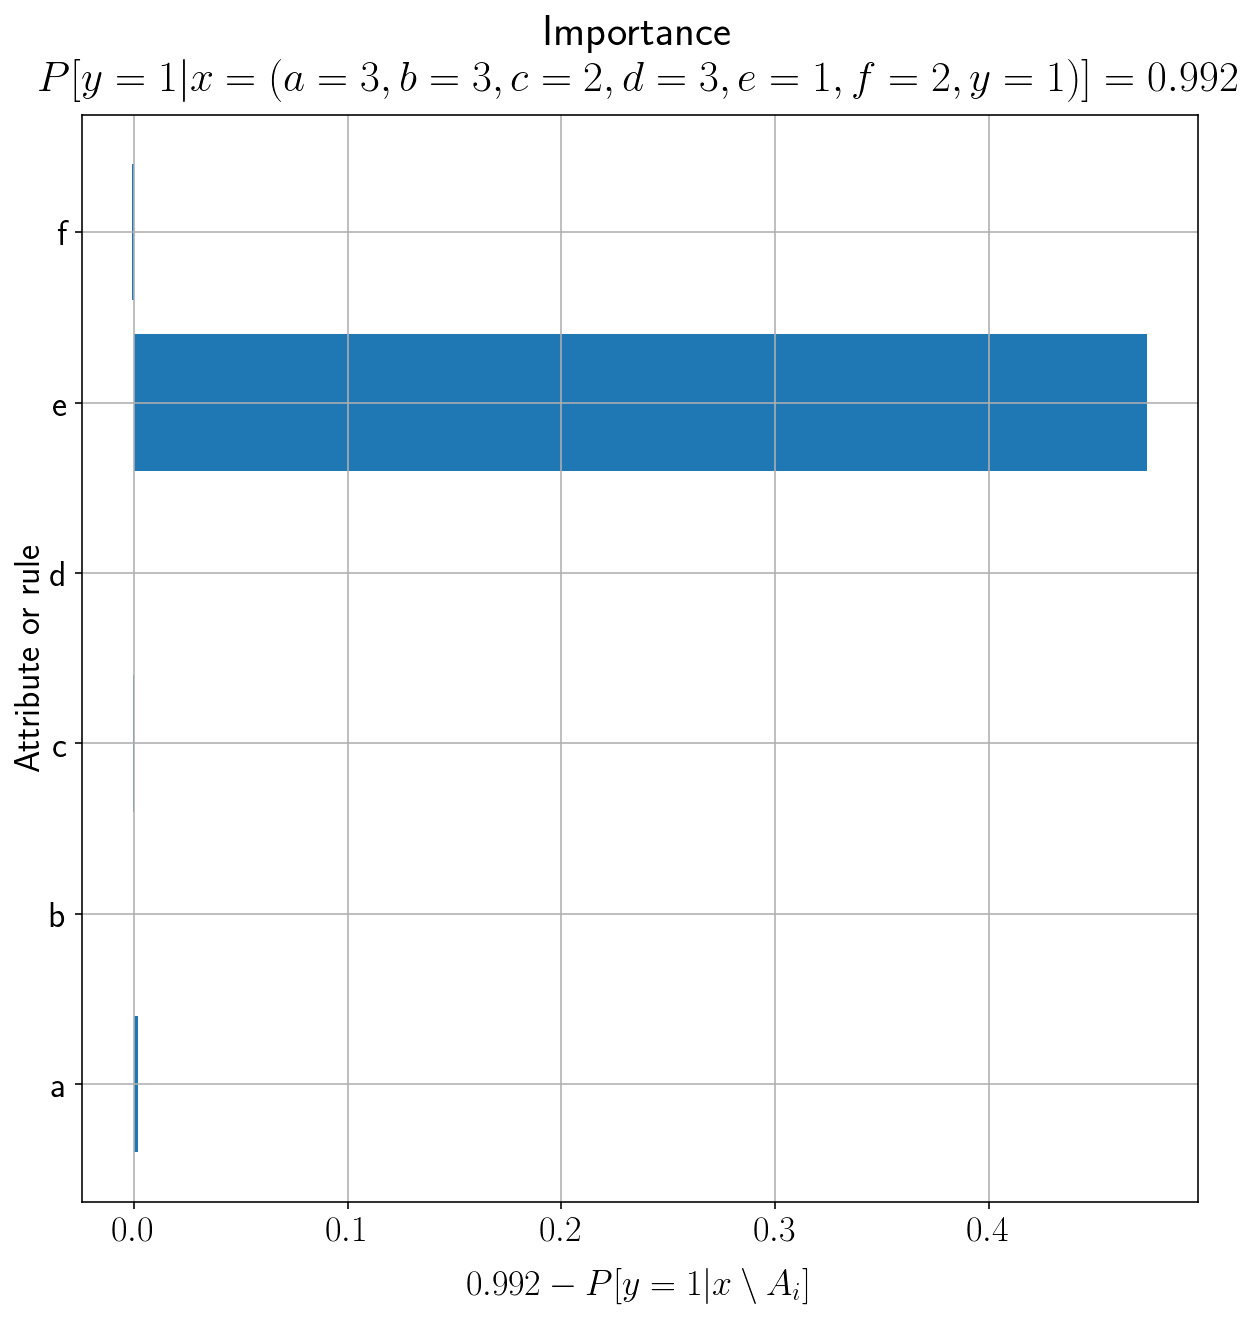

In [12]:
plot(get_explanation(3, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_categorical_nb"))

## Random Forest

In [13]:
evaluate(join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_rf")

1.0

### 0
a==b, e!=1 quindi y=1 perche' a==b. Giustamente RF da importanza ad a, b, a&b

compute_lace_step k=21
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1

{1, 2} a=1, b=1 -> 1
{1, 7} a=1, b=2 -> 0
{8, 2, 3, 6} a=2, b=1, c=1, f=2 -> 0

Rules: [[1, 2]]

compute_lace_step k=42
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1

{1, 2} a=1, b=1 -> 1
{2, 13} a=2, b=1 -> 0
{1, 11} a=1, b=2 -> 0

Rules: [[1, 2]]

compute_lace_step k=63
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1

{1, 2} a=1, b=1 -> 1
{2, 7} a=2, b=1 -> 0
{1, 10} a=1, b=2 -> 0
{13} f=1 -> 1

Rules: [[1, 2]]

compute_lace_step k=84
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1

{1, 2} a=1, b=1 -> 1
{1, 13} a=1, b=2 -> 0
{2, 14} a=2, b=1 -> 0
{3, 13, 14} a=2, b=2, c=1 -> 1

Rules: [[1, 2]]

compute_lace_step k=105
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1

{1, 2} a=1, b=1 -> 1
{1, 12} a=1, b=2 -> 0
{8, 2} a=2, b=1 -> 0
{8, 12} a=2, b=2 -> 1

Rules: [[1, 2]]

compute_lace_step k=126
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1

{1, 2} a=1, b=1 -> 1
{1, 12} a=1, b=2 -> 0
{8, 2} a=2, b=1 -> 0
{8, 12} a=2, b=2 -> 1

Rules: [[

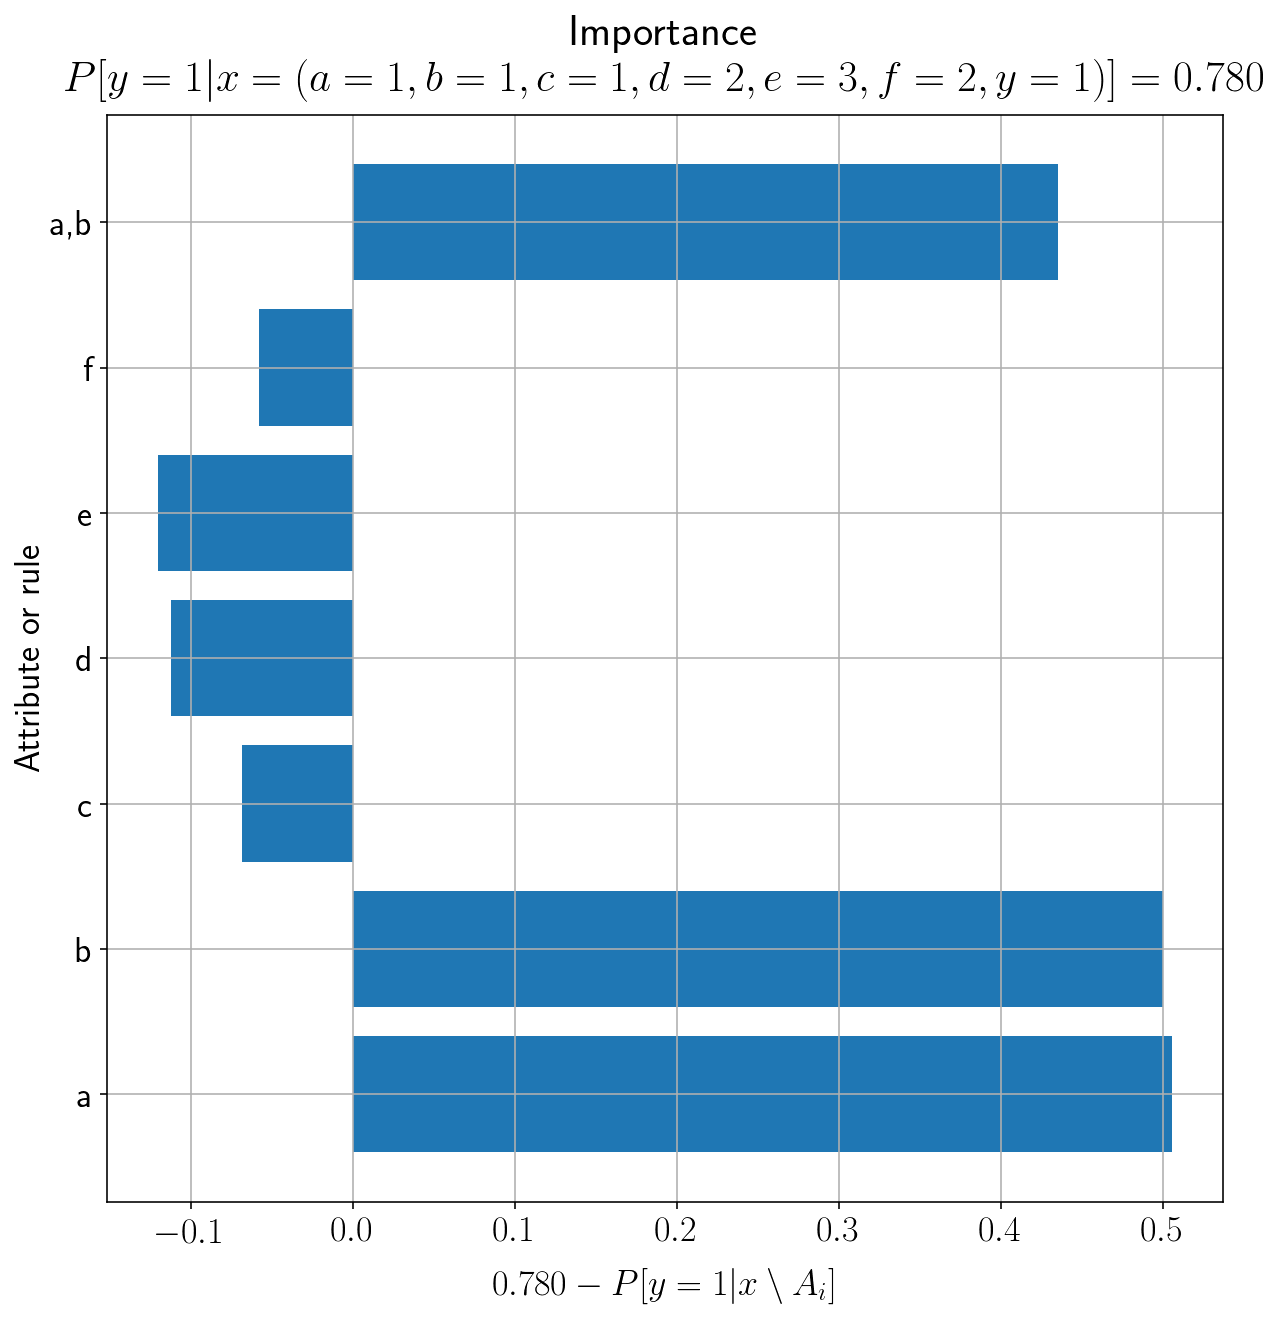

In [14]:
plot(get_explanation(0, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_rf"))

### 1
a==b, e!=1 quindi y=1 perche' a==b. Giustamente RF da importanza ad a, b, a&b

compute_lace_step k=21
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1

{1, 2} a=2, b=2 -> 1
{1, 3, 4, 6, 11} a=2, b=1, c=1, d=2, f=2 -> 0
{2, 3, 4, 13} a=3, b=2, c=1, d=2 -> 0
{2, 3, 5, 6, 9} a=1, b=2, c=1, e=3, f=2 -> 0

Rules: [[1, 2]]

compute_lace_step k=42
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1

{1, 2} a=2, b=2 -> 1
{12} b=1 -> 0
{2, 3, 14} a=3, b=2, c=1 -> 0
{16, 1} a=2, b=3 -> 0
{9, 2} a=1, b=2 -> 0

Rules: [[1, 2]]

compute_lace_step k=63
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1

{1, 2} a=2, b=2 -> 1
{1, 11} a=2, b=1 -> 0
{1, 15} a=2, b=3 -> 0
{2, 12} a=1, b=2 -> 0
{11, 4} b=1, d=2 -> 0
{4, 12} a=1, d=2 -> 0
{2, 13} a=3, b=2 -> 0

Rules: [[1, 2]]

compute_lace_step k=84
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1

{1, 2} a=2, b=2 -> 1
{1, 15} a=2, b=3 -> 0
{1, 7} a=2, b=1 -> 0
{2, 12} a=1, b=2 -> 0
{2, 13} a=3, b=2 -> 0
{12, 6, 7} a=1, b=1, f=2 -> 1
{15} b=3 -> 0
{13} a=3 -> 0

Rules: [[1, 2]]

compute_lace_step k=105
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1

{1, 2} a=2

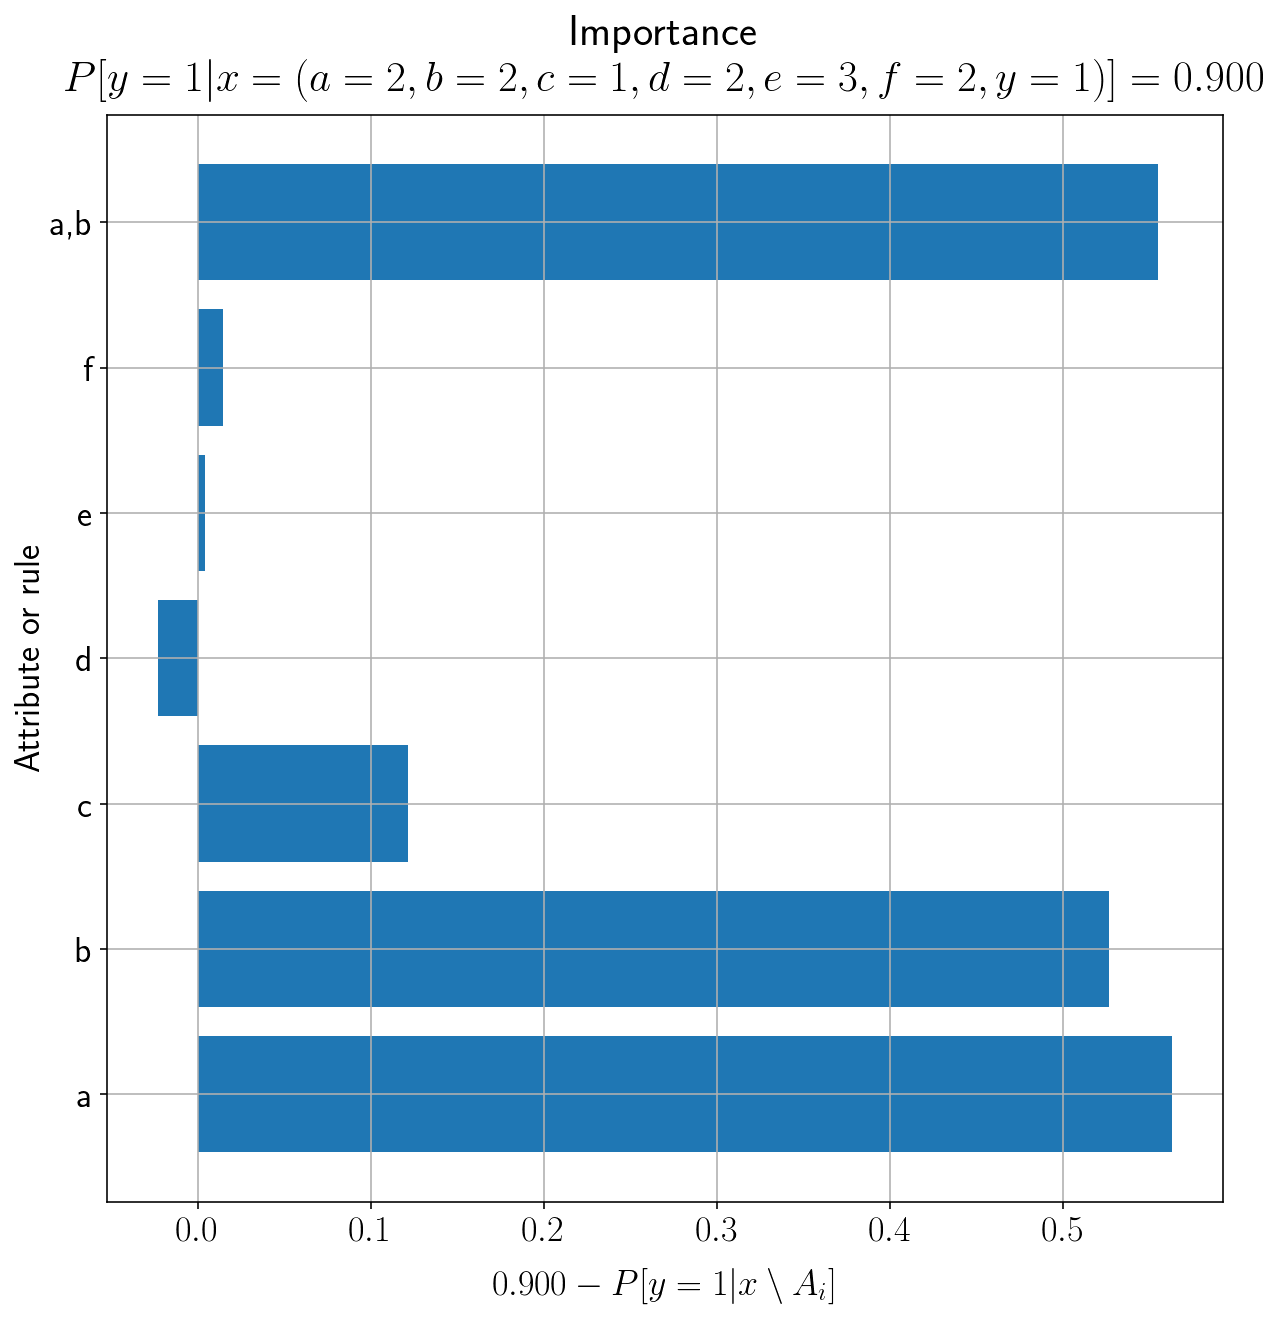

In [15]:
plot(get_explanation(1, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_rf"))

### 2
a!=b, e=1 quindi y=1 perche' e=1. Giustamente RF da importanza ad e.

compute_lace_step k=21
Instance: a=1, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{3, 12} c=2, e=2 -> 0

Rules: [[5]]

compute_lace_step k=42
Instance: a=1, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{2, 11} b=3, e=2 -> 0
{1, 11} a=1, e=2 -> 0
{8, 12} a=2, b=2 -> 1

Rules: [[5]]

compute_lace_step k=63
Instance: a=1, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{2, 11} b=3, e=2 -> 0
{10, 12} a=2, b=2 -> 1
{1, 11} a=1, e=2 -> 0
{1, 2, 6, 14} a=1, b=3, e=3, f=2 -> 0

Rules: [[5]]

compute_lace_step k=84
Instance: a=1, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{11, 7} a=2, b=2 -> 1
{1, 2, 12} a=1, b=3, e=2 -> 0
{9, 2, 12} b=3, e=2, f=1 -> 0
{8, 1, 12} a=1, d=2, e=2 -> 0
{14} e=3 -> 0
{2, 10, 12} b=3, c=1, e=2 -> 0
{2, 11, 12} a=2, b=3, e=2 -> 0
{1, 12, 7} a=1, b=2, e=2 -> 0

Rules: [[5]]

compute_lace_step k=105
Instance: a=1, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{11, 7} a=2, b=2 -> 1
{13} e=3 -> 0
{1, 2, 12} a=1, b=3, e=2 -> 0
{2, 10, 12} b=3, c=1, e=2 -> 0
{1, 14} a=1, b=1 -> 1
{2, 

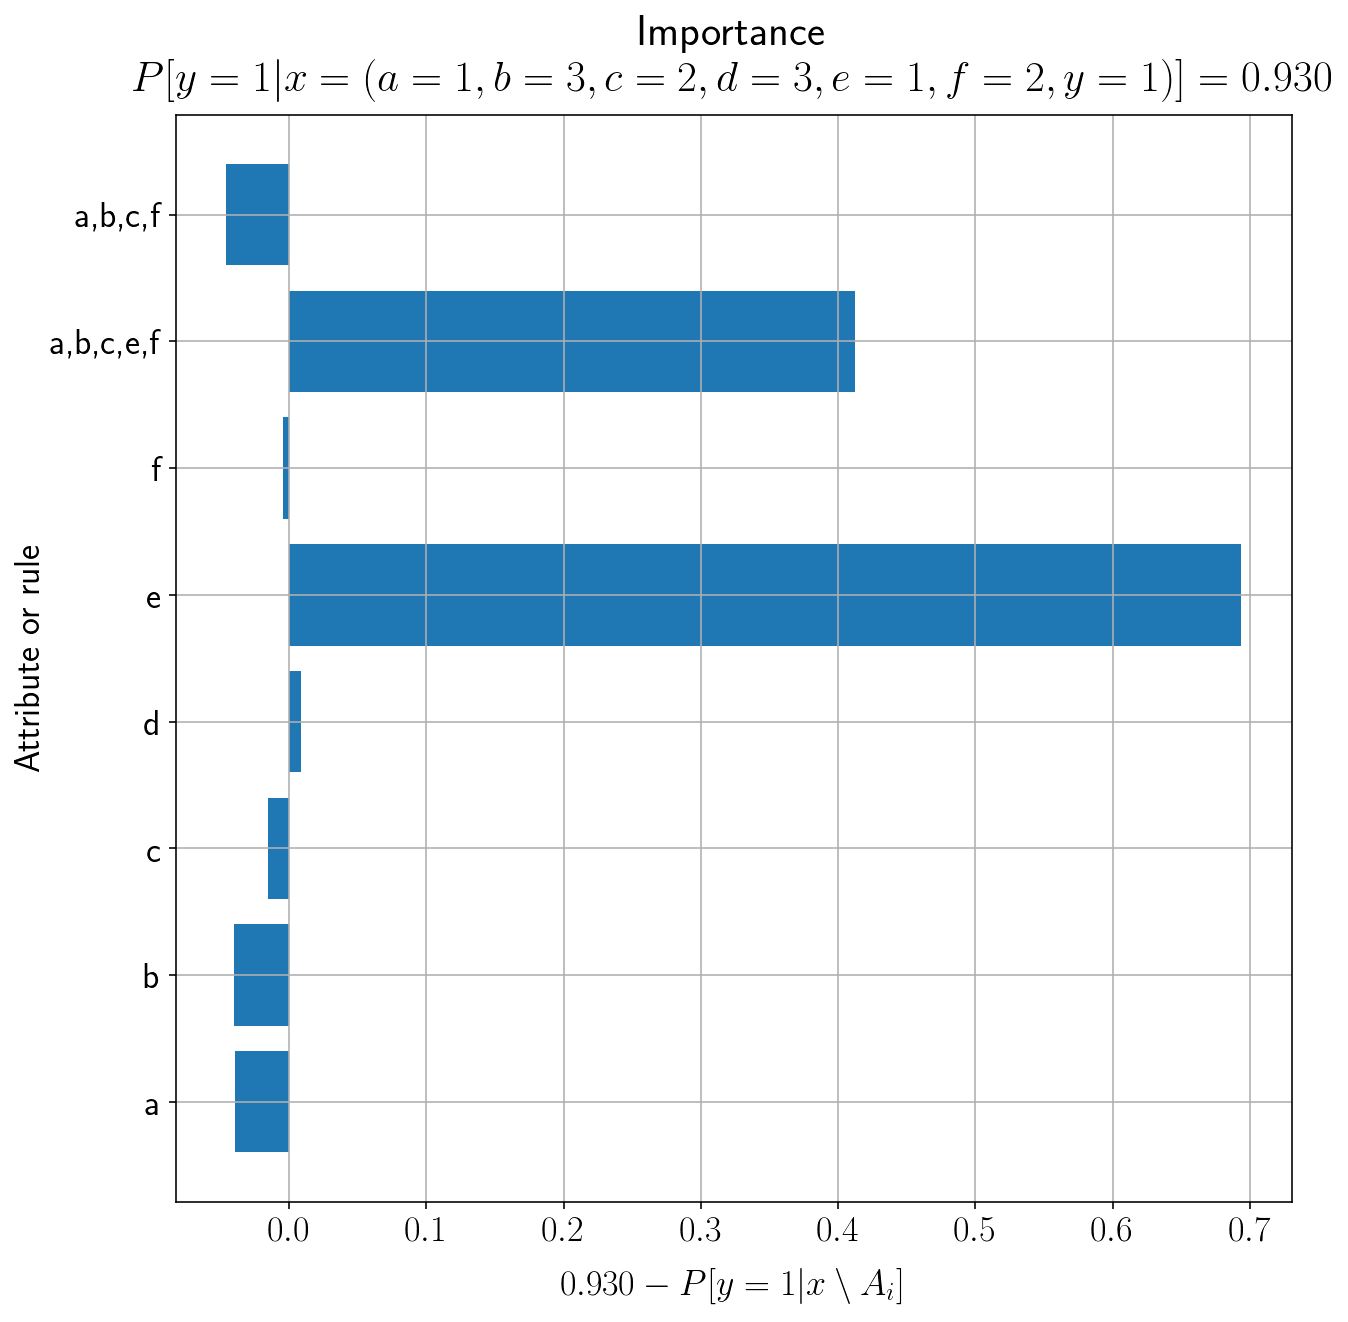

In [16]:
plot(get_explanation(2, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_rf"))

### 3
a==b, e=1 quindi y=1 perche a==b, e=1. Giustamente RF da importanza a,b,e perche' vanno cambiati tutti e tre assieme per avere un effetto

compute_lace_step k=21
Instance: a=3, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{1, 3, 4, 6, 11, 12} a=3, b=2, c=2, d=3, e=2, f=2 -> 0
{2, 3, 4, 6, 8, 11} a=2, b=3, c=2, d=3, e=2, f=2 -> 0

Rules: [[5]]

compute_lace_step k=42
Instance: a=3, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{1, 2} a=3, b=3 -> 1
{1, 11, 4, 12} a=3, b=2, d=3, e=2 -> 0
{2, 11, 4, 7} a=2, b=3, d=3, e=2 -> 0

Rules: [[5], [1, 2]]

explain_instance errors: 4.356E-01, 1.783E-02


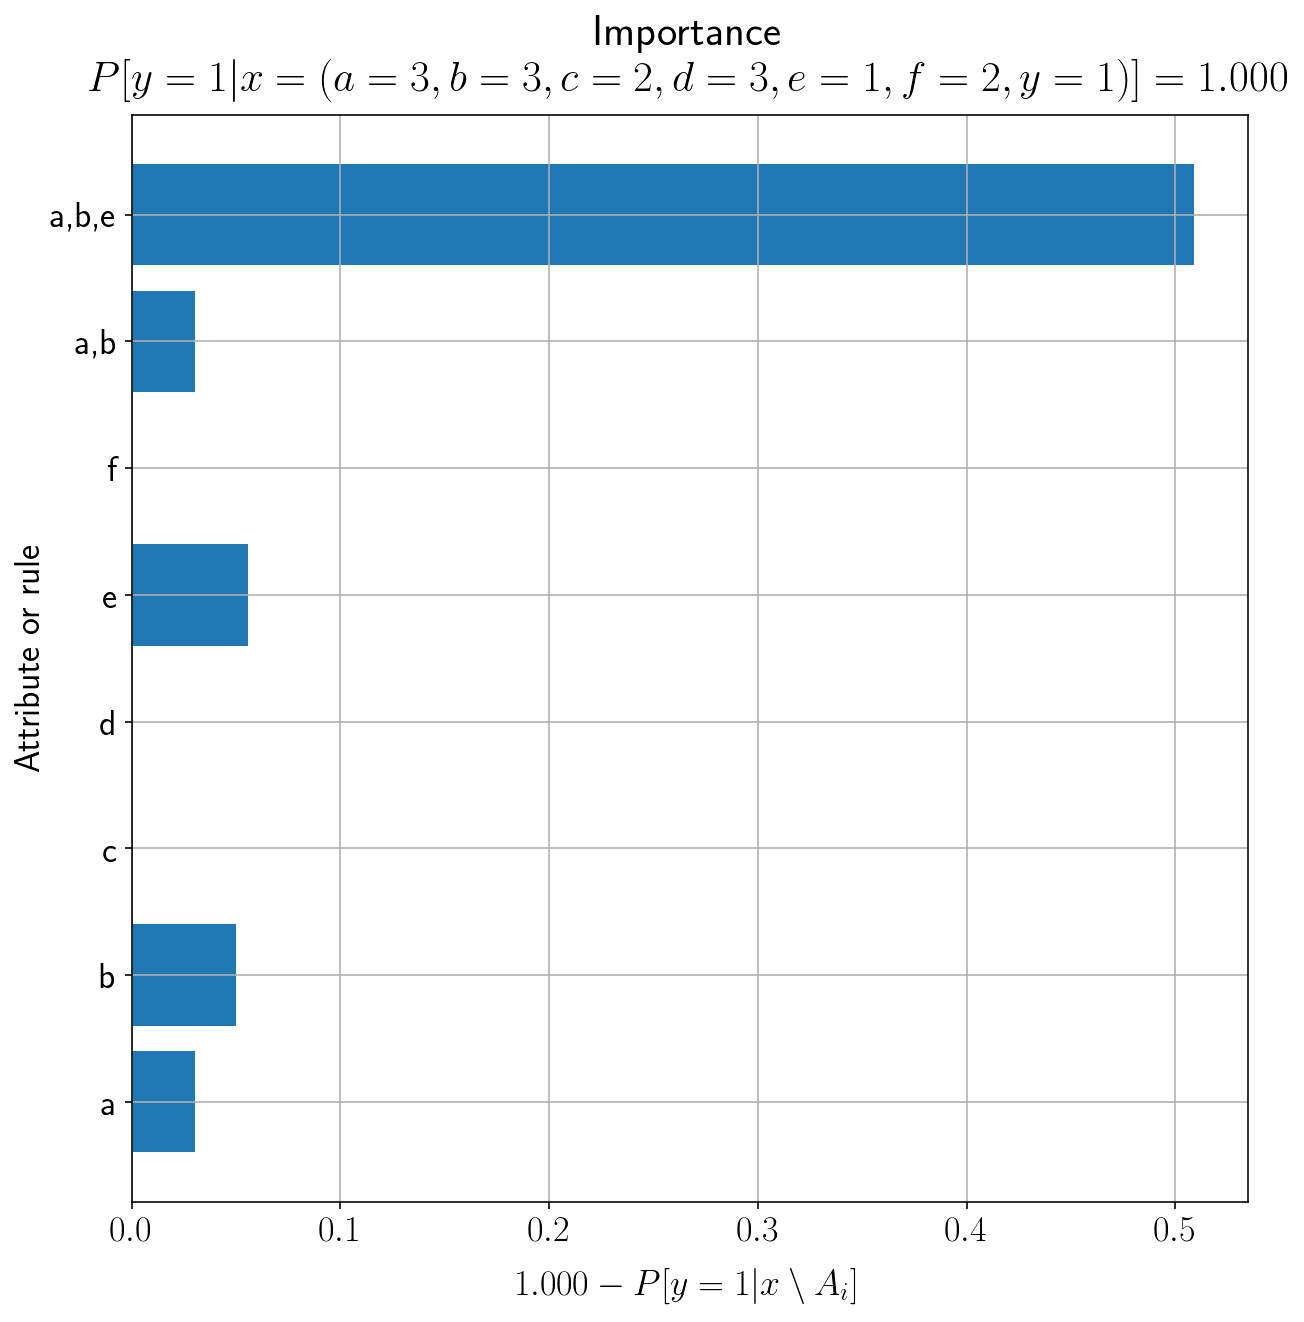

In [17]:
plot(get_explanation(3, join(DEFAULT_DIR, "datasets/monks.arff"), "sklearn_rf"))

## Neural Network

In [18]:
evaluate(join(DEFAULT_DIR, "datasets/monks.arff"), "nn_onehot_enc")

1.0

### 0
a==b, e!=1 quindi y=1 perche' a==b. Giustamente NN da importanza ad a, b, a&b

compute_lace_step k=21
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1

{1, 2} a=1, b=1 -> 1
{1, 7} a=1, b=2 -> 0
{8, 2, 3, 6} a=2, b=1, c=1, f=2 -> 0

Rules: [[1, 2]]

compute_lace_step k=42
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1

{1, 2} a=1, b=1 -> 1
{2, 13} a=2, b=1 -> 0
{1, 11} a=1, b=2 -> 0

Rules: [[1, 2]]

compute_lace_step k=63
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1

{1, 2} a=1, b=1 -> 1
{2, 7} a=2, b=1 -> 0
{1, 10} a=1, b=2 -> 0
{13} f=1 -> 1

Rules: [[1, 2]]

compute_lace_step k=84
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1

{1, 2} a=1, b=1 -> 1
{1, 13} a=1, b=2 -> 0
{2, 14} a=2, b=1 -> 0
{3, 13, 14} a=2, b=2, c=1 -> 1

Rules: [[1, 2]]

compute_lace_step k=105
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1

{1, 2} a=1, b=1 -> 1
{1, 12} a=1, b=2 -> 0
{8, 2} a=2, b=1 -> 0
{8, 12} a=2, b=2 -> 1

Rules: [[1, 2]]

compute_lace_step k=126
Instance: a=1, b=1, c=1, d=2, e=3, f=2, y=1

{1, 2} a=1, b=1 -> 1
{1, 12} a=1, b=2 -> 0
{8, 2} a=2, b=1 -> 0
{8, 12} a=2, b=2 -> 1

Rules: [[

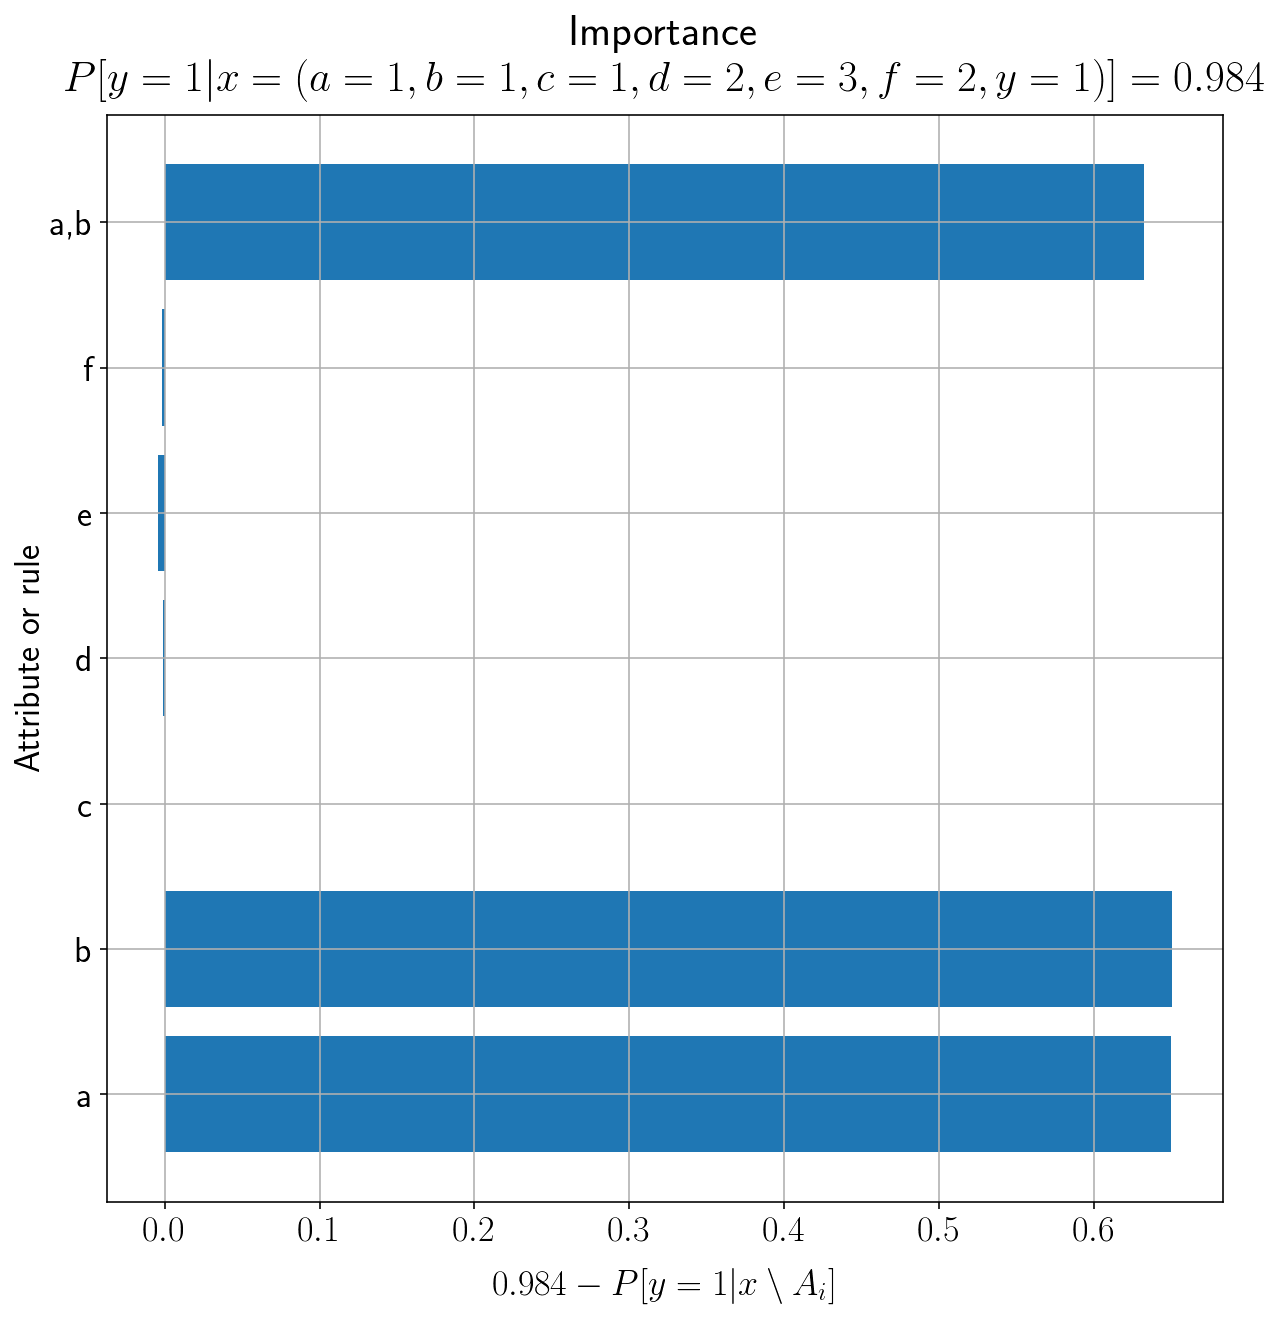

In [19]:
plot(get_explanation(0, join(DEFAULT_DIR, "datasets/monks.arff"), "nn_onehot_enc"))

### 1
a==b, e!=1 quindi y=1 perche' a==b. Giustamente NN da importanza ad a, b, a&b

compute_lace_step k=21
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1

{1, 2} a=2, b=2 -> 1
{1, 3, 4, 6, 11} a=2, b=1, c=1, d=2, f=2 -> 0
{2, 3, 4, 13} a=3, b=2, c=1, d=2 -> 0
{2, 3, 5, 6, 9} a=1, b=2, c=1, e=3, f=2 -> 0

Rules: [[1, 2]]

compute_lace_step k=42
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1

{1, 2} a=2, b=2 -> 1
{12} b=1 -> 0
{2, 3, 14} a=3, b=2, c=1 -> 0
{16, 1} a=2, b=3 -> 0
{9, 2} a=1, b=2 -> 0

Rules: [[1, 2]]

compute_lace_step k=63
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1

{1, 2} a=2, b=2 -> 1
{1, 11} a=2, b=1 -> 0
{1, 15} a=2, b=3 -> 0
{2, 12} a=1, b=2 -> 0
{11, 4} b=1, d=2 -> 0
{4, 12} a=1, d=2 -> 0
{2, 13} a=3, b=2 -> 0

Rules: [[1, 2]]

compute_lace_step k=84
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1

{1, 2} a=2, b=2 -> 1
{1, 15} a=2, b=3 -> 0
{1, 7} a=2, b=1 -> 0
{2, 12} a=1, b=2 -> 0
{2, 13} a=3, b=2 -> 0
{12, 6, 7} a=1, b=1, f=2 -> 1
{15} b=3 -> 0
{13} a=3 -> 0

Rules: [[1, 2]]

compute_lace_step k=105
Instance: a=2, b=2, c=1, d=2, e=3, f=2, y=1

{1, 2} a=2

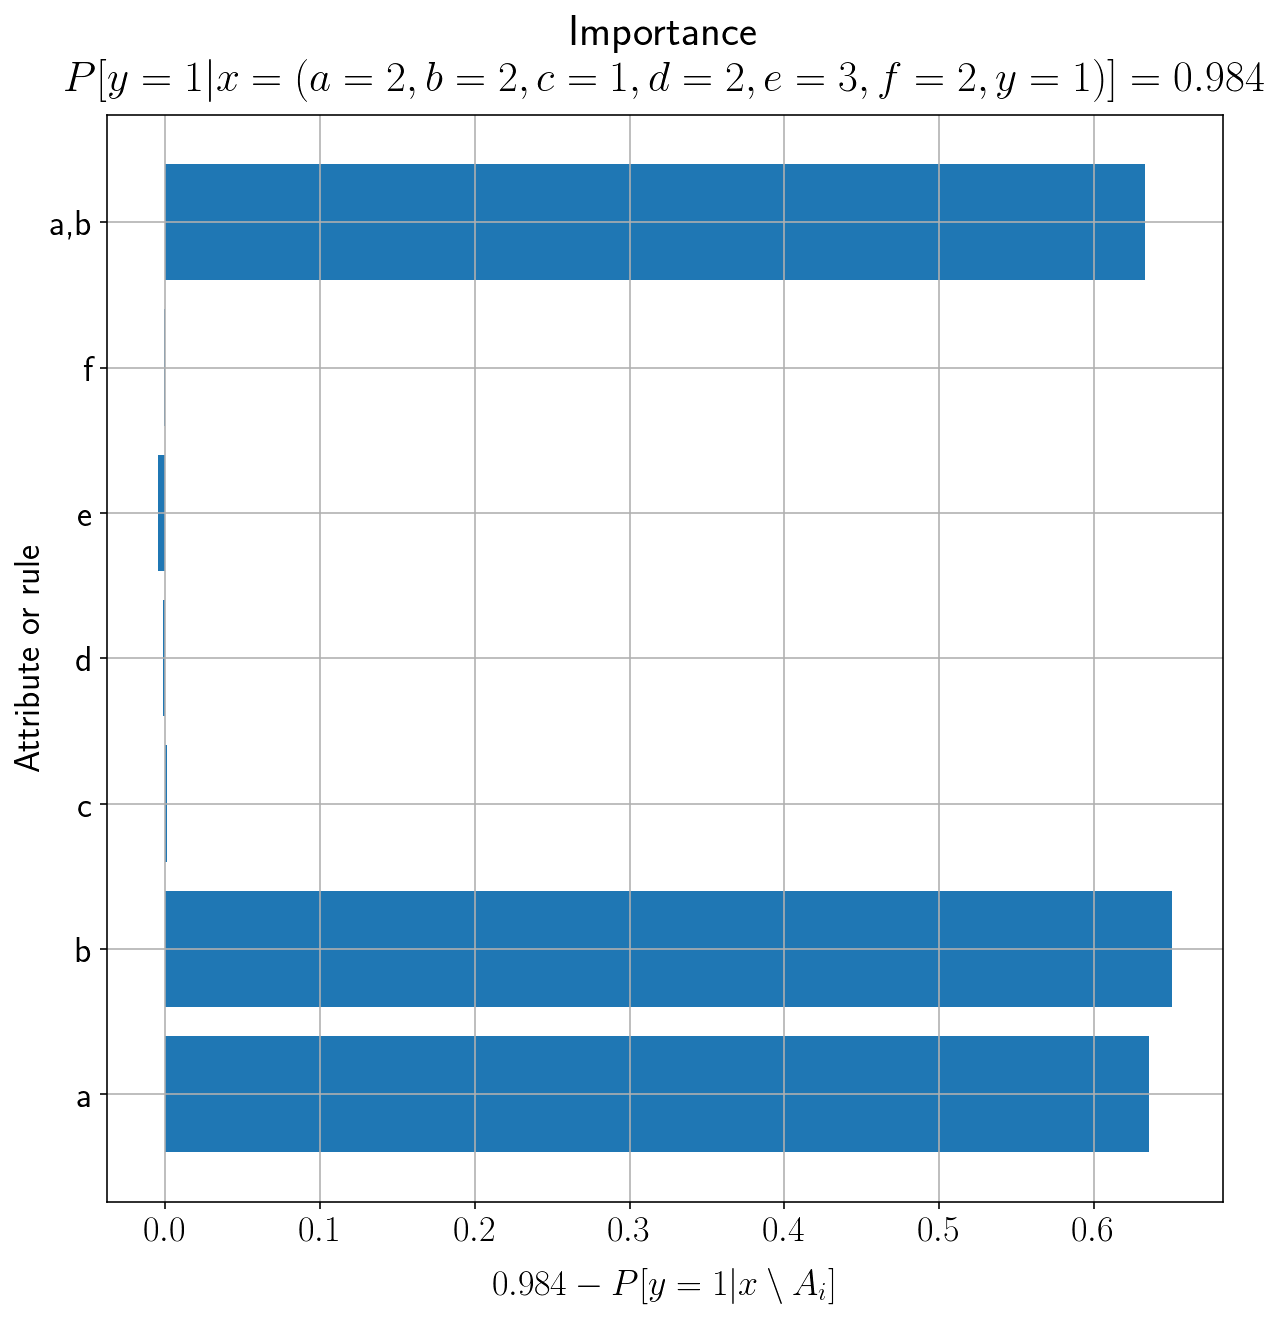

In [20]:
plot(get_explanation(1, join(DEFAULT_DIR, "datasets/monks.arff"), "nn_onehot_enc"))

### 2
a!=b, e=1 quindi y=1 perche' e=1. Giustamente NN da importanza ad e

compute_lace_step k=21
Instance: a=1, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{3, 12} c=2, e=2 -> 0

Rules: [[5]]

compute_lace_step k=42
Instance: a=1, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{2, 11} b=3, e=2 -> 0
{1, 11} a=1, e=2 -> 0
{8, 12} a=2, b=2 -> 1

Rules: [[5]]

compute_lace_step k=63
Instance: a=1, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{2, 11} b=3, e=2 -> 0
{10, 12} a=2, b=2 -> 1
{1, 11} a=1, e=2 -> 0
{1, 2, 6, 14} a=1, b=3, e=3, f=2 -> 0

Rules: [[5]]

compute_lace_step k=84
Instance: a=1, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{11, 7} a=2, b=2 -> 1
{1, 2, 12} a=1, b=3, e=2 -> 0
{9, 2, 12} b=3, e=2, f=1 -> 0
{8, 1, 12} a=1, d=2, e=2 -> 0
{14} e=3 -> 0
{2, 10, 12} b=3, c=1, e=2 -> 0
{2, 11, 12} a=2, b=3, e=2 -> 0
{1, 12, 7} a=1, b=2, e=2 -> 0

Rules: [[5]]

compute_lace_step k=105
Instance: a=1, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{11, 7} a=2, b=2 -> 1
{13} e=3 -> 0
{1, 2, 12} a=1, b=3, e=2 -> 0
{2, 10, 12} b=3, c=1, e=2 -> 0
{1, 14} a=1, b=1 -> 1
{2, 

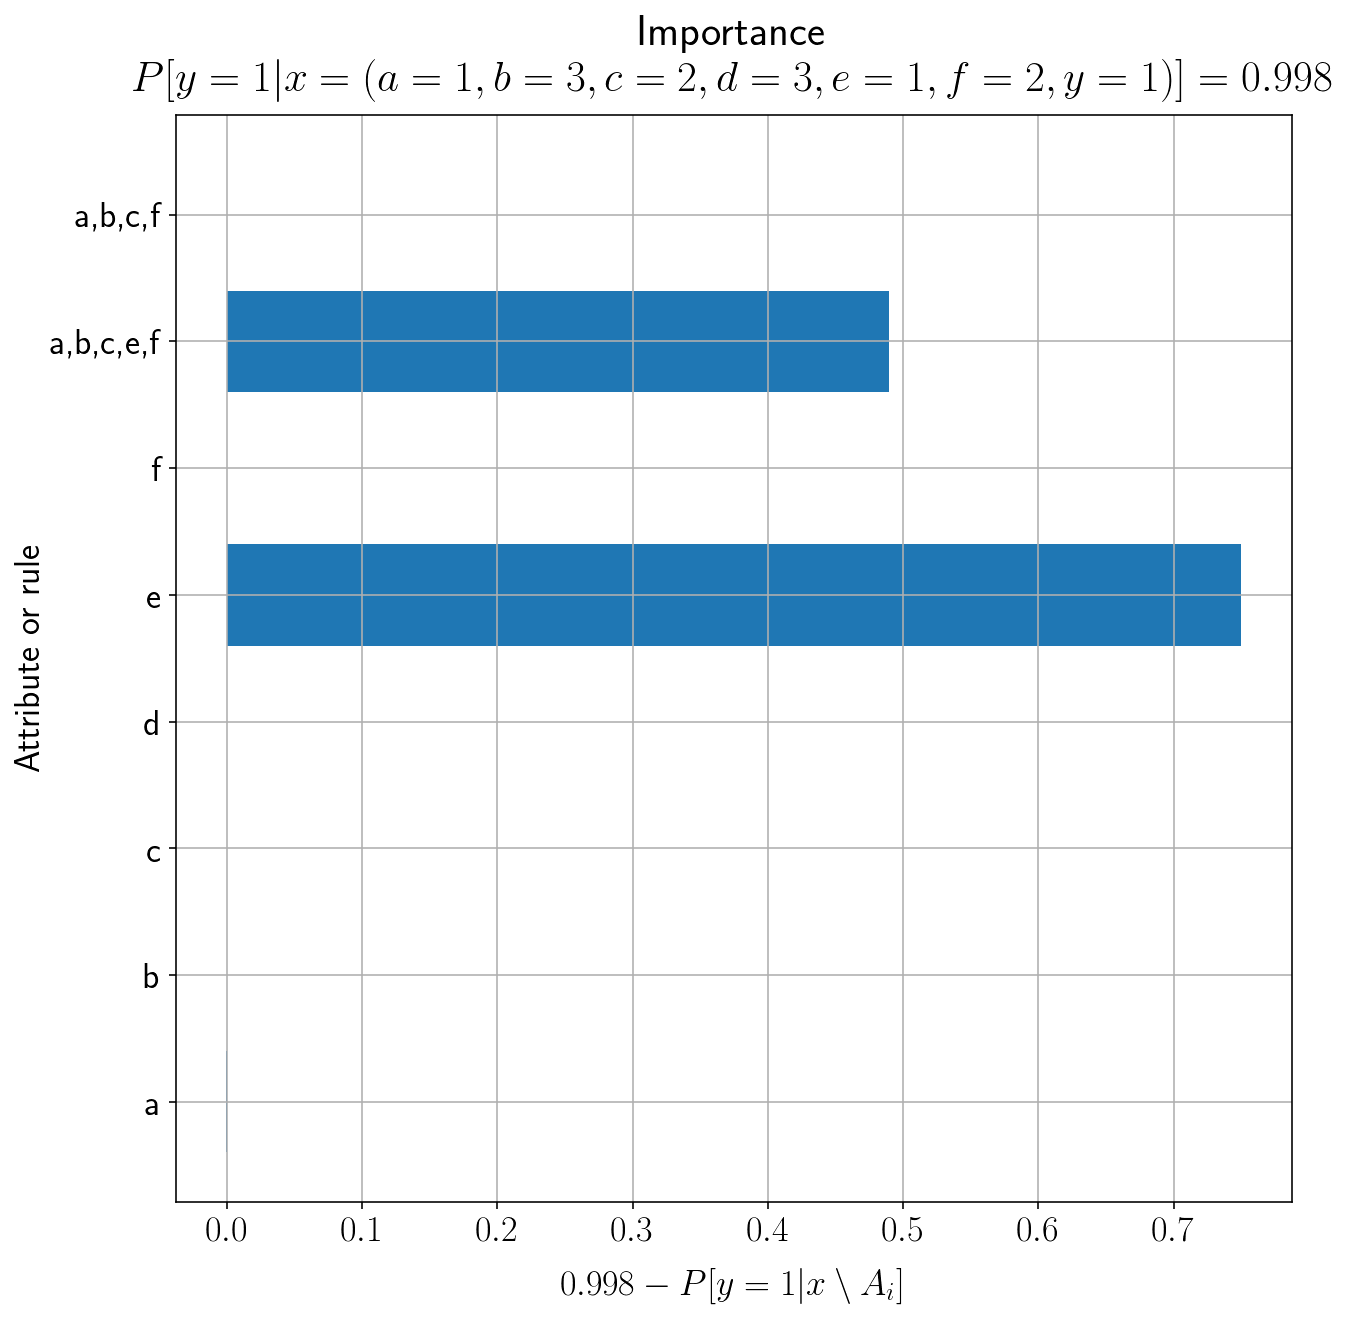

In [21]:
plot(get_explanation(2, join(DEFAULT_DIR, "datasets/monks.arff"), "nn_onehot_enc"))

### 3
a==b, e=1 quindi y=1 perche a==b, e=1. Giustamente NN da importanza a,b,e perche' vanno cambiati tutti e tre assieme per avere un effetto

compute_lace_step k=21
Instance: a=3, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{1, 3, 4, 6, 11, 12} a=3, b=2, c=2, d=3, e=2, f=2 -> 0
{2, 3, 4, 6, 8, 11} a=2, b=3, c=2, d=3, e=2, f=2 -> 0

Rules: [[5]]

compute_lace_step k=42
Instance: a=3, b=3, c=2, d=3, e=1, f=2, y=1

{5} e=1 -> 1
{1, 2} a=3, b=3 -> 1
{1, 11, 4, 12} a=3, b=2, d=3, e=2 -> 0
{2, 11, 4, 7} a=2, b=3, d=3, e=2 -> 0

Rules: [[5], [1, 2]]

explain_instance errors: 4.816E-01, 6.065E-04


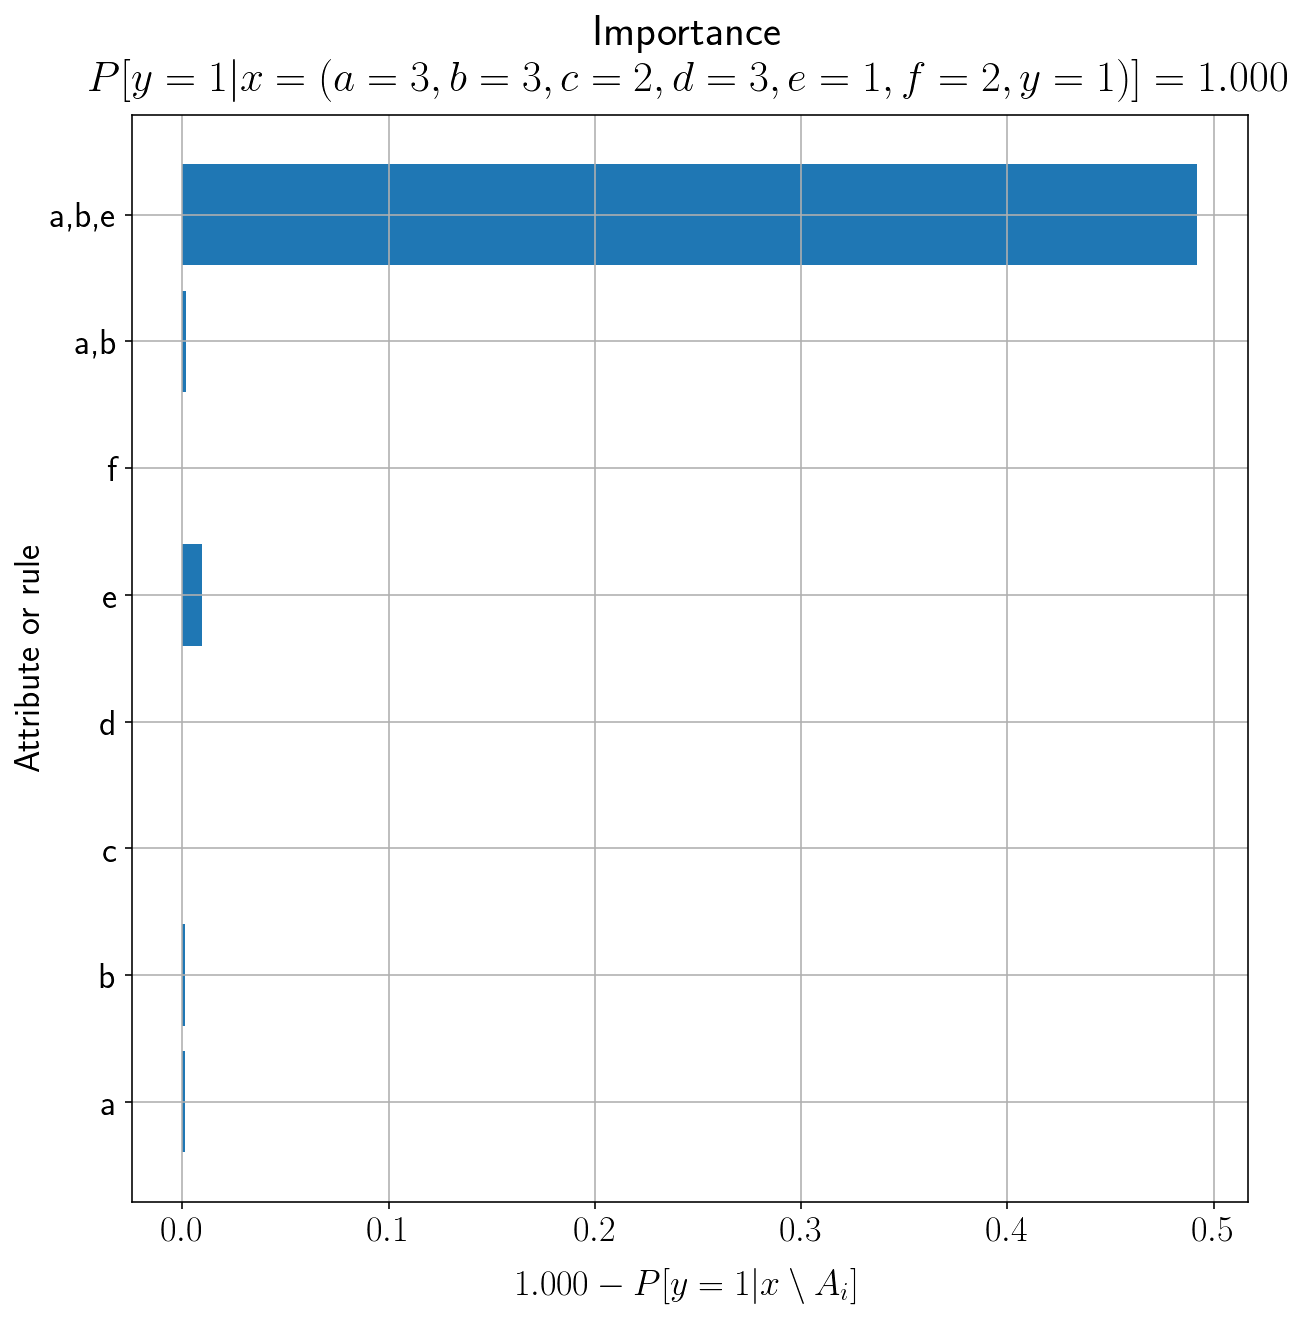

In [22]:
plot(get_explanation(3, join(DEFAULT_DIR, "datasets/monks.arff"), "nn_onehot_enc"))